In [1]:
import matplotlib.pyplot as plt
import aniposelib
%matplotlib widget
import numpy as np
import pandas as pd
import os, cv2, sys, shutil

## Choosing Equidistant Points on a tail

In [431]:
calibration_ = aniposelib.cameras.CameraGroup.load('/mnt/soma_cifs/Iyer/Filming/02112022a/calibrationwater_1515/calibration.toml')

In [457]:
def get_traces():
    folder = '76_9605-11135'
    img_n = '0593'
    p0 = np.load(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam0-Aditya-2022-11-04/labeled-data/{folder}/Camera1img{img_n}_pts00000.npy')
    p1 = np.load(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/{folder}/Camera1img{img_n}_pts00000.npy')
    p2 = np.load(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam2-Aditya-2022-11-04/labeled-data/{folder}/Camera1img{img_n}_pts00000.npy')
    return p0, p1, p2

In [458]:
def get_imgs():
    img_n = '0593'
    folder = '76_9605-11135'
    p0 = cv2.imread(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam0-Aditya-2022-11-04/labeled-data/{folder}/img{img_n}.png')
    p1 = cv2.imread(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/{folder}/img{img_n}.png')
    p2 = cv2.imread(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam2-Aditya-2022-11-04/labeled-data/{folder}/img{img_n}.png')
    return p0, p1, p2

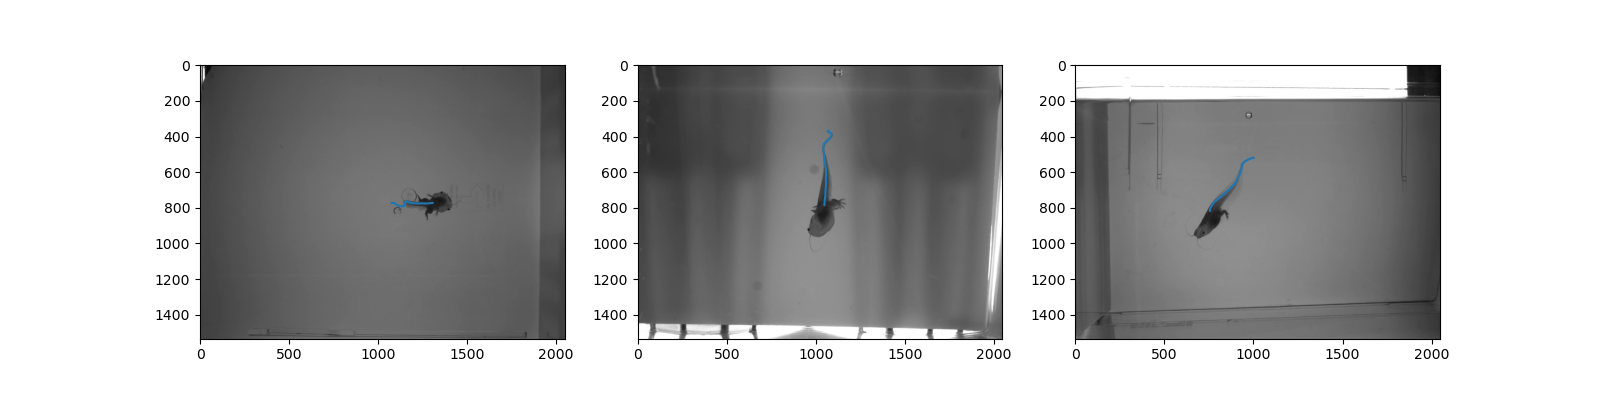

In [459]:
p0, p1, p2 = get_traces()
i0, i1, i2 = get_imgs()
pts_ = np.array([p0, p1, p2]).reshape(3, -1, 2)
fig, ax = plt.subplots(1,3,figsize = (16,4))
ax[0].imshow(i0)
ax[0].plot(p0[:,0], p0[:,1])

ax[1].imshow(i1)
ax[1].plot(p1[:,0], p1[:,1])

ax[2].imshow(i2)
ax[2].plot(p2[:,0], p2[:,1])

In [460]:
# In this case, Camera1 and Camera2 (not Camera0) are more likely to return appropriate correspondences

In [461]:
pts_pairs = np.zeros((3, 100*100, 2))
pts_pairs[0] = np.nan
for i in range(100):
    for j in range(100):
        pts_pairs[1][i*100 + j] = p1[i]
        pts_pairs[2][i*100 + j] = p2[j]

pts3d = calibration_.triangulate(pts_pairs, progress=True)
reproj_err = calibration_.reprojection_error(pts3d, pts_pairs, mean=True)
residuals_ = np.reshape(reproj_err, (100, 100))

100%|█████████████████████████| 10000/10000 [00:05<00:00, 1956.56it/s]


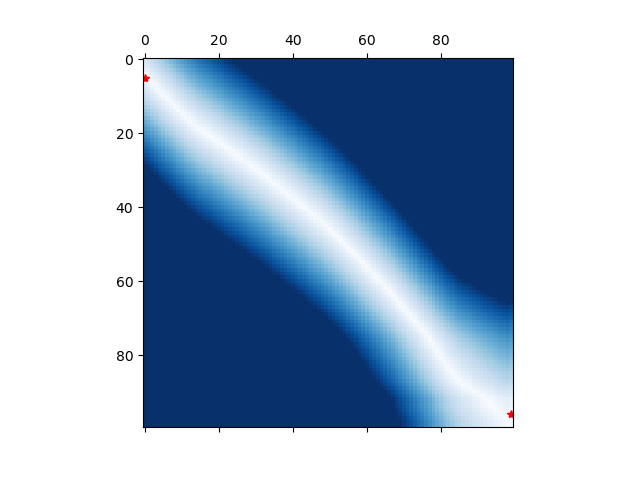

In [462]:
fig, ax = plt.subplots()
ax.matshow(residuals_, cmap = plt.cm.Blues, vmin =0, vmax = 50)
if(min(residuals_[:,0]) < min(residuals_[0])):
    start_ = [np.argmin(residuals_[:,0]), 0]
else:
    start_ = [0, np.argmin(residuals_[0])]
    
plt.plot(start_[1], start_[0], 'r*')

if(min(residuals_[:,99]) < min(residuals_[99])):
    end_ = [np.argmin(residuals_[:,99]), 99]
else:
    end_ = [99, np.argmin(residuals_[99])]
    
plt.plot(end_[1], end_[0], 'r*')

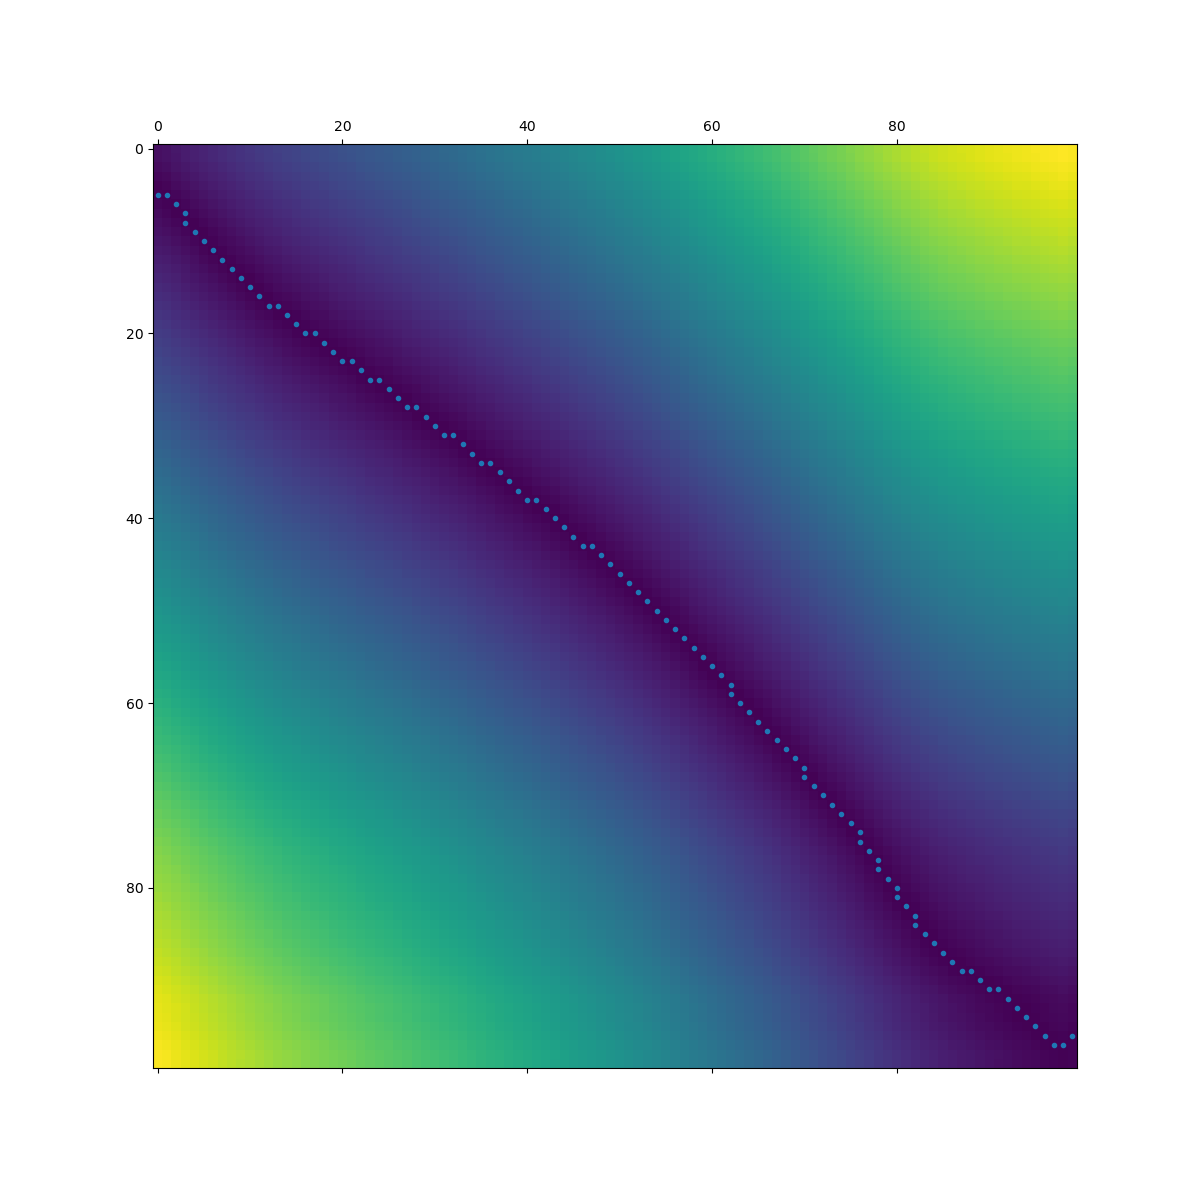

In [463]:
path_ = djikstra_walk(residuals_, start_, end_)
fig, ax = plt.subplots(figsize = (12,12))
ax.matshow(residuals_)
ax.plot(path_[:,1], path_[:,0], '.')

[0.8841214  0.74341323 0.48209255 0.36969441 0.80878249 0.49602359
 0.56803785 0.56356972 0.89078233 0.64210977]


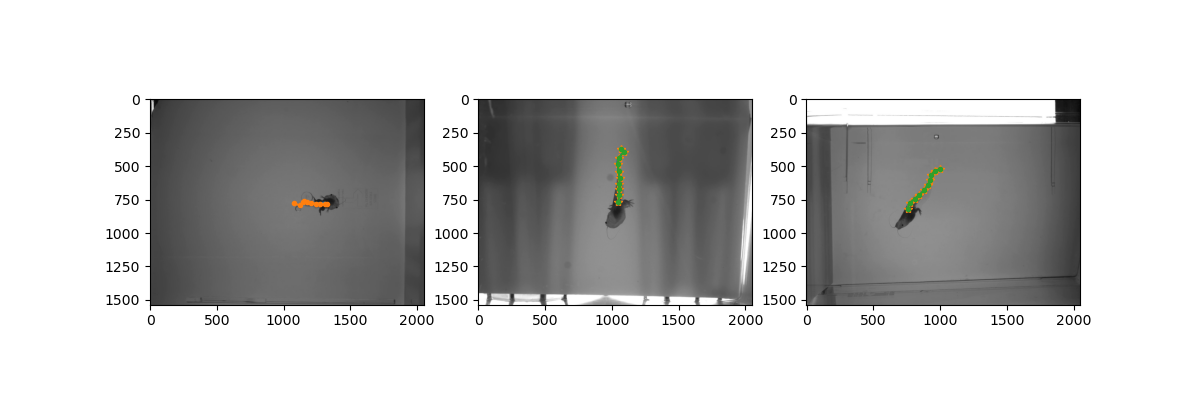

In [464]:
fig, ax = plt.subplots(1,3,figsize = (12,4))
ax[0].imshow(i0)
ax[0].plot(p0[:,0], p0[:,1])
ax[1].plot(p1[:,0], p1[:,1])
ax[2].plot(p2[:,0], p2[:,1])

slice_ = np.rint(np.linspace(0, len(path_)-1, 10)).astype(np.int32)
x = path_[slice_,0]
y = path_[slice_,1]


ax[1].imshow(i1)
ax[1].plot(p1[x,0], p1[x,1], '*')

ax[2].imshow(i2)
ax[2].plot(p2[y,0], p2[y,1], '*')

pts_ = np.array([p1[x], p1[x], p2[y]])
pts_[0] = np.nan
tail3d = calibration_.triangulate(pts_)
calibration_.reprojection_error(tail3d, pts_, mean = True)
pts_reproj = calibration_.project(tail3d)

ax[0].plot(pts_reproj[0][:,0], pts_reproj[0][:,1], '.-')
ax[1].plot(pts_reproj[1][:,0], pts_reproj[1][:,1], '.-')
ax[2].plot(pts_reproj[2][:,0], pts_reproj[2][:,1], '.-')
print(calibration_.reprojection_error(tail3d, pts_, mean = True))

In [408]:
def djikstra_walk(array_, start_, end_):
    '''
    Finds the shortest path through the array_ using Djikstra's algorithm
    '''
    #Initiate all the required arrays
    #curr_ = np.array([0, np.argmin(residuals_[0])])
    curr_ = np.array(start_, dtype = np.int32)
    visited_ = np.zeros(array_.shape, dtype = np.bool_)
    previous_ = np.zeros((array_.shape[0], array_.shape[1], 2), dtype = np.int32)
    previous_[tuple(curr_)] = [-1, -1]
    distances_ = np.ones(array_.shape)*np.inf
    distances_[tuple(curr_)] = array_[tuple(curr_)]
    path_ = []

    while True:
        visited_[tuple(curr_)] = 1
        min_ = np.inf
        neighbours = get_neighbours(array_.shape, curr_)
        for ng in neighbours:
            # Update Distances
            if distances_[tuple(curr_)] + array_[tuple(ng)] < distances_[tuple(ng)]:
                distances_[tuple(ng)] = distances_[tuple(curr_)] + array_[tuple(ng)]
                previous_[tuple(ng)] = curr_
        distances_1 = np.copy(distances_);
        distances_1[np.where(visited_)] = np.inf
        curr_ = np.array(np.unravel_index(np.argmin(distances_1), distances_1.shape))
        if curr_[0] == end_[0] and curr_[1] == end_[1]:
            break
    # Traceback the path from the linked list
    while (curr_ != [-1, -1]).all():
        path_.append(curr_)
        curr_ = previous_[tuple(curr_)]
    path_ = np.flip(path_, axis = 0)

    return path_

In [409]:
def get_neighbours(shp, curr_):
    x = range(max(0, curr_[0] - 1),min(curr_[0] + 2, shp[0]))
    y = range(max(0, curr_[1] - 1),min(curr_[1] + 2, shp[1]))
    neighbours = np.array(np.meshgrid(x,y)).T.reshape(-1, 2)
    return neighbours

In [465]:
def djikstra_walk(array_):
    '''
    Finds the shortest path through the array_ using Djikstra's algorithm
    '''
    #Initiate all the required arrays
    #curr_ = np.array([0, np.argmin(residuals_[0])])
    curr_ = np.array([0,0], dtype = np.int32)
    visited_ = np.zeros(array_.shape, dtype = np.bool_)
    previous_ = np.zeros((array_.shape[0], array_.shape[1], 2), dtype = np.int32)
    previous_[tuple(curr_)] = [-1, -1]
    distances_ = np.ones(array_.shape)*np.inf
    distances_[tuple(curr_)] = array_[tuple(curr_)]
    path_ = []

    while True:
        visited_[tuple(curr_)] = 1
        min_ = np.inf
        neighbours = get_neighbours(array_.shape, curr_)
        for ng in neighbours:
            # Update Distances
            if distances_[tuple(curr_)] + array_[tuple(ng)] < distances_[tuple(ng)]:
                distances_[tuple(ng)] = distances_[tuple(curr_)] + array_[tuple(ng)]
                previous_[tuple(ng)] = curr_
        distances_1 = np.copy(distances_);
        distances_1[np.where(visited_)] = np.inf
        curr_ = np.array(np.unravel_index(np.argmin(distances_1), distances_1.shape))
        if curr_[0] == 99 and curr_[1] == 99:
            break
    # Traceback the path from the linked list
    while (curr_ != [-1, -1]).all():
        path_.append(curr_)
        curr_ = previous_[tuple(curr_)]
    path_ = np.flip(path_, axis = 0)

    return path_